## Importing Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi

%matplotlib inline

In [2]:
# Function for saving the figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "AirBnB-London-2020"
IMAGES_PATH = "../reports/figures/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Function for applying a new format to the numerical columns so that they can be explored
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def text_to_int(self):
        self = self.str.split(' ').str[0].replace('Half-bath', '0.5', regex=True).replace('Shared', '0.5', regex=True) \
                                         .replace('Private', '1', regex=True).astype('float')
              
        return self

In [4]:
# Function for finding outliers
def find_outliers(df_listings, column_name):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings[column_name], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings[column_name],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings[column_name] >= Q1 - step) & 
                                  (df_listings[column_name] <= Q3 + step))].sort_values(by=[column_name])
    
    return filtered_data

### Importing the Data

In [5]:
df_listings = pd.read_csv('../data/raw/listings.csv', low_memory=False)

In [6]:
df_listings.shape

(77136, 74)

In [7]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,90%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",$105.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",$40.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",$75.00,10,50,10.0,10.0,50.0,50.0,10.0,50.0,

## Data Exploration

In [8]:
# General statistics of the data
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.713600e+04,7.713600e+04,7.713600e+04,77095.000000,77095.000000,0.0,77136.000000,77136.000000,77136.000000,0.0,72284.000000,75992.000000,77136.000000,7.713600e+04,77135.000000,77135.000000,7.713500e+04,7.713500e+04,77135.000000,7.713500e+04,0.0,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,77136.000000,52965.000000,52902.000000,52911.000000,52855.000000,52904.000000,52856.000000,52855.000000,0.0,77136.000000,77136.000000,77136.000000,77136.000000,54705.000000
mean,2.598945e+07,2.020122e+13,9.675921e+07,24.170374,24.170374,NaN,51.510106,-0.128107,3.070006,NaN,1.488587,1.707811,5.180564,2.069624e+04,5.452855,6.908913,1.878365e+05,7.724969e+05,5.979946,7.222697e+05,NaN,11.320590,24.534757,38.320356,122.106046,15.283823,1.583891,0.045439,93.044652,9.525746,9.284270,9.649134,9.669231,9.557212,9.300974,NaN,20.686631,17.525993,2.618259,0.036559,0.607957
std,1.340272e+07,2.074232e+01,1.018449e+08,125.710654,125.710654,NaN,0.047450,0.094877,1.951961,NaN,0.884982,1.284529,22.401630,4.066635e+06,23.192706,30.399336,1.937087e+07,4.037594e+07,25.947365,3.774108e+07,NaN,13.215171,26.900944,40.683909,144.228420,35.440263,4.581973,0.319414,10.531457,1.033406,1.186098,0.931390,0.929136,0.869663,1.077889,NaN,98.922987,96.070725,16.523581,0.509314,0.865626
min,1.155100e+04,2.020122e+13,2.010000e+03,0.000000,0.000000,NaN,51.292570,-0.496870,0.000000,NaN,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.526581e+07,2.020122e+13,1.627615e+07,1.000000,1.000000,NaN,51.484497,-0.188510,2.000000,NaN,1.000000,1.000000,1.000000,3.100000e+01,1.000000,1.000000,9.000000e+01,9.000000e+01,1.000000,9.000000e+01,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.110000
50%,2.623901e+07,2.020122e+13,4.997764e+07,1.000000,1.000000,NaN,51.514230,-0.126040,2.000000,NaN,1.000000,1.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,NaN,0.000000,3.000000,13.000000,57.000000,3.000000,0.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,1.000000,0.000000,0.320000
75%,3.816095e+07,2.020122e+13,1.558912e+08,3.000000,3.000000,NaN,51.539340,-0.069387,4.000000,NaN,2.000000,2.000000,3.000000,1.125000e+03,4.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,NaN,28.000000,58.000000,88.000000,262.000000,14.000000,1.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,2.000000,1.000000,0.000000,0.780000
max,4.707231e+07,2.020122e+13,3.803358e+08,3450.000000,3450.000000,NaN,51.679980,0.288570,16.000000,NaN,50.000000,50.000000,1125.000000,1.000000e+09,1125.000000,1125.000000,2.147484e+09,2.147484e+09,1125.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,817.000000,479.000000,22.000000,100.000000,10.000000,10.

In [9]:
# Dataframe columns information
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77136 entries, 0 to 77135
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            77136 non-null  int64  
 1   listing_url                                   77136 non-null  object 
 2   scrape_id                                     77136 non-null  int64  
 3   last_scraped                                  77136 non-null  object 
 4   name                                          77112 non-null  object 
 5   description                                   74048 non-null  object 
 6   neighborhood_overview                         47437 non-null  object 
 7   picture_url                                   77136 non-null  object 
 8   host_id                                       77136 non-null  int64  
 9   host_url                                      77136 non-null 

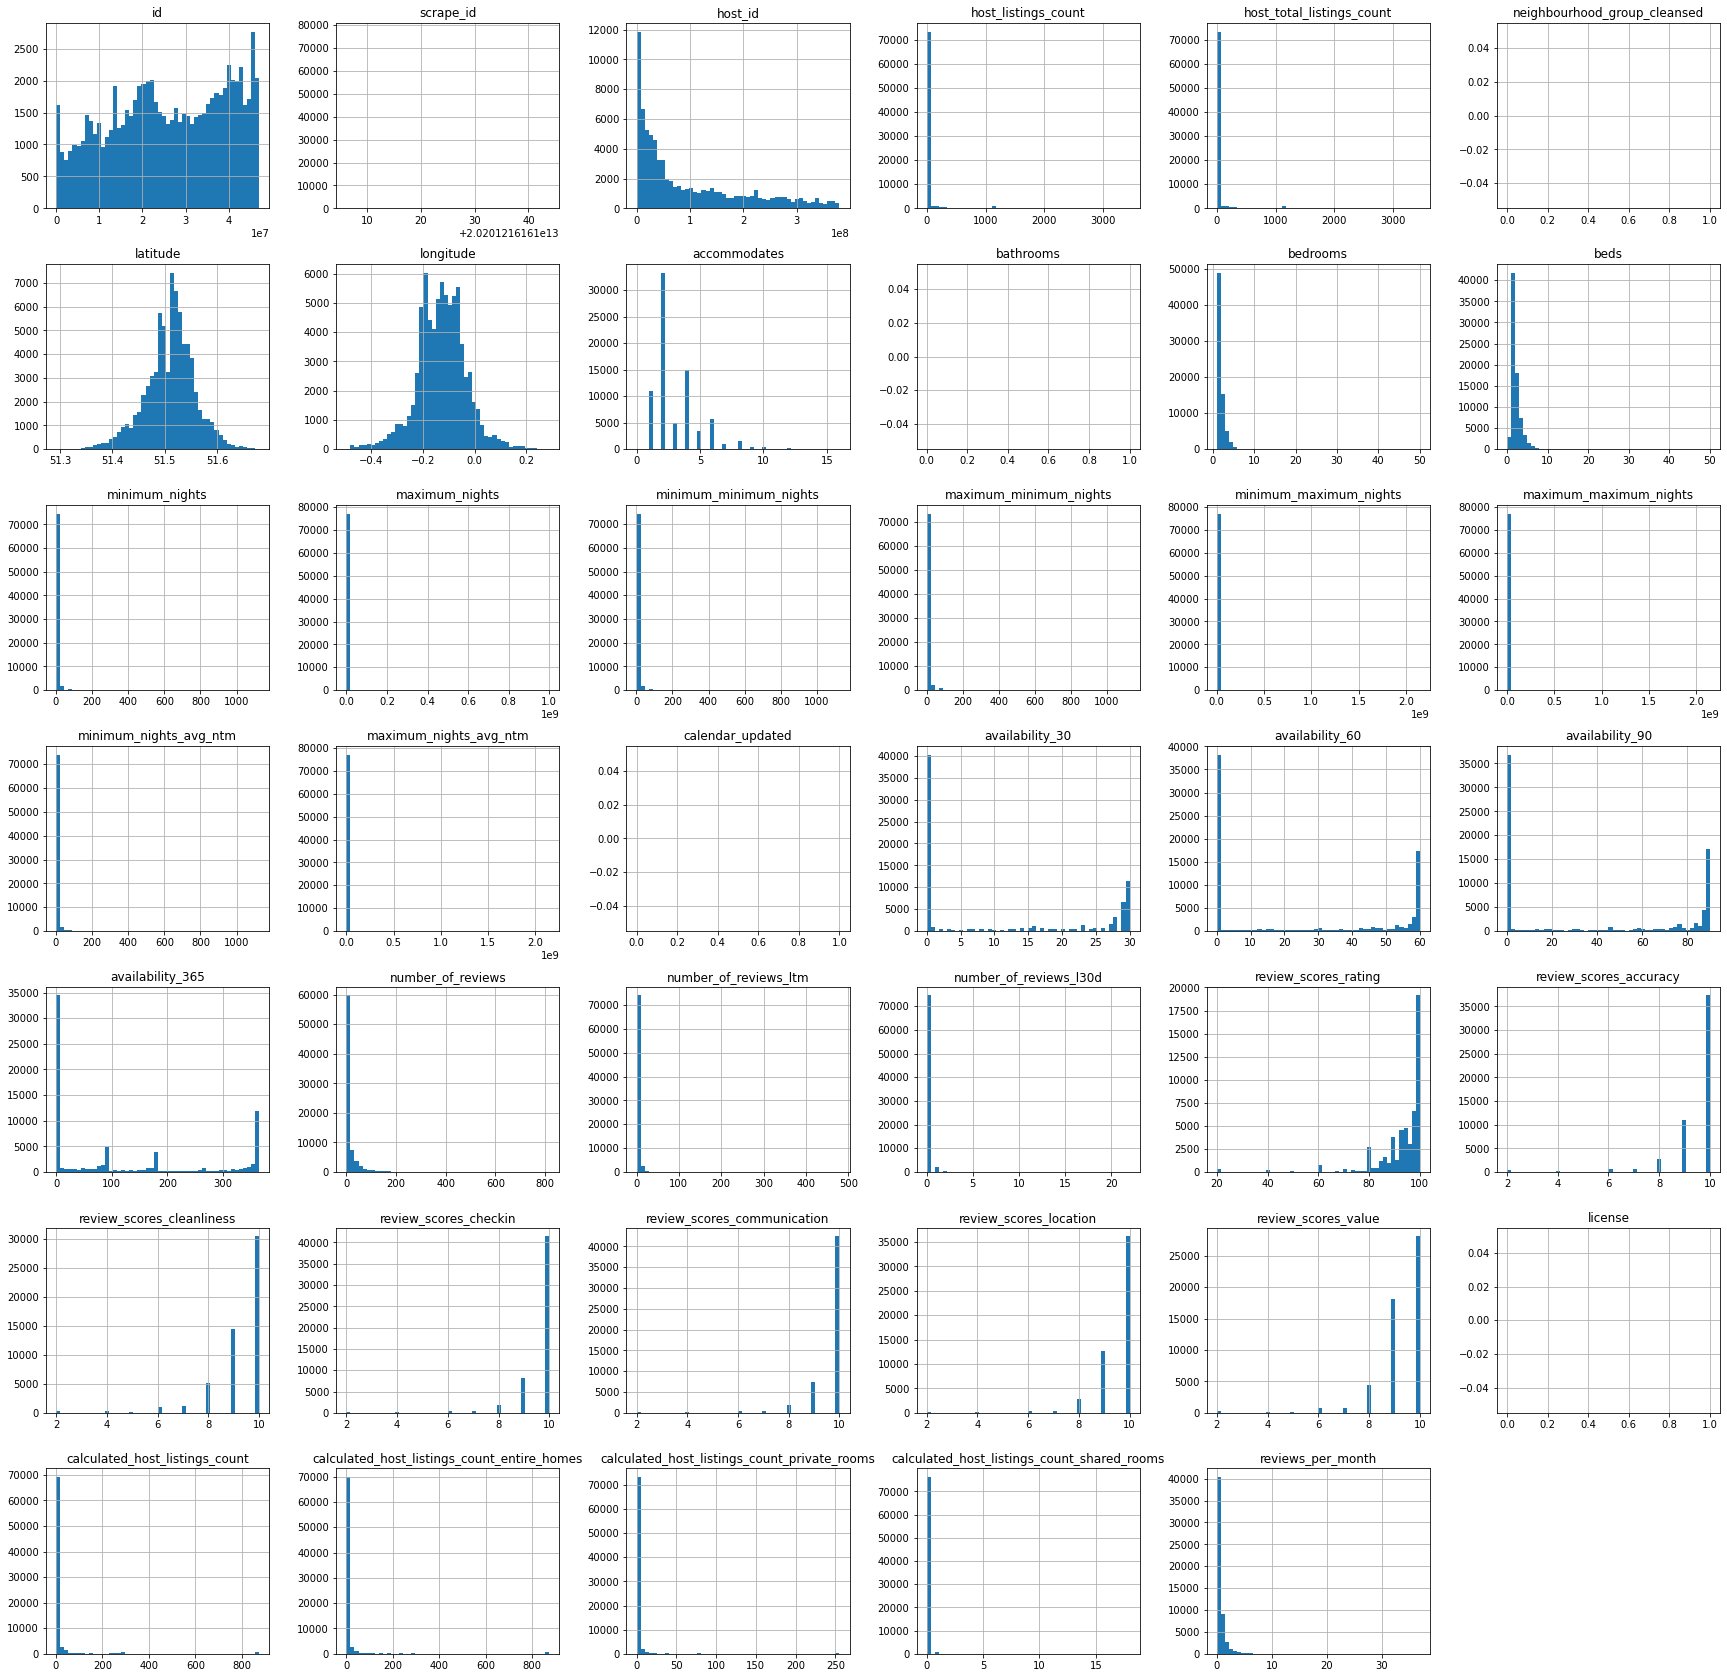

In [10]:
# Checking the distribution of all variables
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [11]:
# Finding the columns with more than 75% of values missing
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed'}

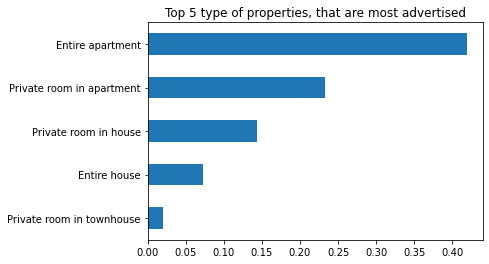

In [13]:
# Exploring the data for number of property types
neighbourhood_vals = df_listings['property_type'].value_counts()

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

In [19]:
neighbourhood_vals[df_listings['property_type'].value_counts() > 100]

Entire apartment                     32292
Private room in apartment            17926
Private room in house                11111
Entire house                          5618
Private room in townhouse             1529
Entire condominium                    1349
Entire serviced apartment             1026
Entire townhouse                       963
Private room in condominium            656
Private room in bed and breakfast      538
Room in boutique hotel                 458
Entire loft                            428
Room in hotel                          303
Shared room in apartment               294
Room in serviced apartment             293
Private room in loft                   244
Private room in guest suite            189
Entire guest suite                     176
Private room in guesthouse             174
Shared room in house                   131
Entire guesthouse                      121
Room in aparthotel                     118
Room in hostel                         109
Private roo

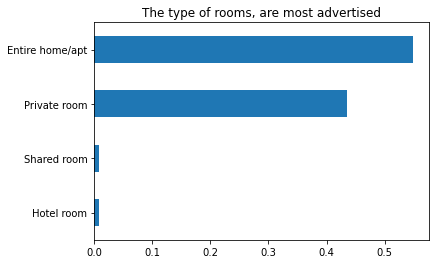

In [20]:
# Exploring the data for number of room types
room_vals = df_listings['room_type'].value_counts()

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

In [23]:
df_listings['room_type'].value_counts()

Entire home/apt    42395
Private room       33558
Shared room          603
Hotel room           580
Name: room_type, dtype: int64

In [24]:
# Exploring the data unique bathrooms
df_listings['bathrooms_text'].value_counts()

1 bath               32520
1 shared bath        14028
2 baths               9175
1 private bath        6014
1.5 baths             5077
1.5 shared baths      3637
2.5 baths             1909
2 shared baths        1367
3 baths               1154
3.5 baths              460
2.5 shared baths       346
4 baths                230
3 shared baths         167
0 shared baths         164
0 baths                154
Half-bath              107
Shared half-bath       105
4.5 baths               91
5 baths                 46
3.5 shared baths        36
Private half-bath       22
6 baths                 21
4 shared baths          20
5.5 baths               20
6 shared baths          19
10 baths                18
4.5 shared baths         8
6.5 baths                8
5 shared baths           7
7 baths                  5
8 baths                  4
8 shared baths           3
7.5 baths                2
8.5 baths                2
7 shared baths           2
12 baths                 1
11.5 baths               1
1

## Data Preparation

In [ ]:
# Applying format to the price column
float_list = ['price']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [ ]:
# Applying format to the host_response_rate and host_acceptance_rate column
percentage_list = ['host_response_rate','host_acceptance_rate']
for x in percentage_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [ ]:
# Applying format to the bathrooms_text column
text_list = ['bathrooms_text']
for x in text_list:
    df_listings[x] = format_data.text_to_int(df_listings[x])

In [ ]:
# Exploring the data unique bathrooms
df_listings['bathrooms_text'].value_counts()

In [ ]:
# Exploring the data unique bedrooms
df_listings['bedrooms'].value_counts()

### Removing Price Outliers

In [ ]:
outliers = find_outliers(df_listings, "price").index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

In [ ]:
# Checking the new distribution of prices
df_listings["price"].hist()

In [ ]:
df_listings.head(3)